In [9]:
load('.RData')

In [10]:
library(FSelector)
library(RColorBrewer)
library(caret)

In [11]:
## Eliminar Mouse 3484
df <- df[df$Mouse != 3484, ]

In [12]:
df.c_s <- df[df$Genotype == 'Control' & df$Treatment == 'Saline', c('Behavior', proteinas)]

## 1. Importance Gain

In [13]:
head(df.c_s)

,Behavior,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,⋯,P3525_N,pCASP9_N,PSD95_N,SNCA_N,Ubiquitin_N,pGSK3B_Tyr216_N,SHH_N,pS6_N,SYP_N,CaNA_N
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3477_1,CS,0.5916184,0.8149799,0.4149799,2.706108,5.256264,0.2609897,0.1872492,4.163798,0.2658939,⋯,0.3161974,1.598026,1.903538,0.1279904,1.1052226,0.7147052,0.2162696,0.1211552,0.4000481,1.399615
3477_2,CS,0.5898067,0.8404449,0.4243253,2.803702,5.534373,0.2694201,0.1928337,4.284555,0.2759847,⋯,0.3231917,1.597113,1.987210,0.1458747,1.0931156,0.7302941,0.2206288,0.1253331,0.3988663,1.410978
3477_3,CS,0.5989016,0.8860412,0.4447597,2.918261,5.717712,0.2904348,0.1971625,4.497666,0.2822883,⋯,0.3040895,1.521701,1.851042,0.1418094,0.9987003,0.6903867,0.2306085,0.1186000,0.3787309,1.332266
3477_4,CS,0.5448436,0.7269988,0.3908459,2.521089,4.967323,0.2755504,0.1909618,4.576825,0.2402086,⋯,0.3019977,1.516816,1.951827,0.1225187,1.0786446,0.7160197,0.2107093,0.1177140,0.3855102,1.394424
3477_5,CS,0.5127852,0.7306502,0.3891756,2.514047,5.070519,0.2718725,0.1886252,4.548217,0.2383901,⋯,0.3260649,1.527257,1.942254,0.1370436,1.0477307,0.7195740,0.2228068,0.1242394,0.3857759,1.366823
3477_6,CS,0.5421644,0.7804849,0.4145476,2.672383,5.691898,0.2835009,0.1986990,4.806978,0.2560615,⋯,0.3139563,1.436650,1.886165,0.1348908,1.0755461,0.7015170,0.2353155,0.1170510,0.3673544,1.320328


In [14]:
options(repr.plot.width = 12, repr.plot.height = 7)

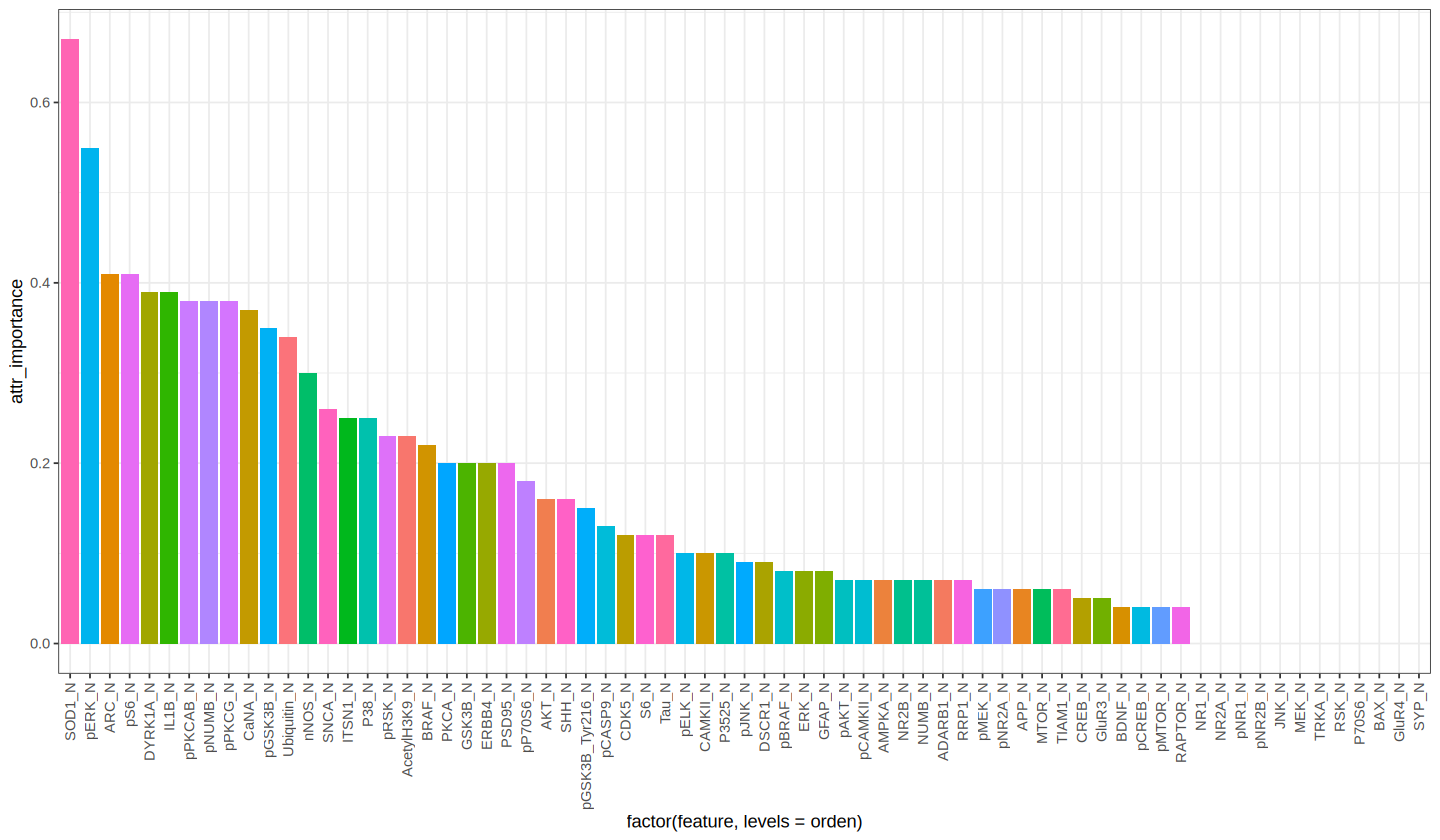

In [15]:
importance <- information.gain(Behavior~., df.c_s[, c('Behavior', proteinas)])
importance$attr_importance <- round(importance$attr_importance, 2)
importance$feature <- rownames(importance)
orden <- importance[order(importance$attr_importance, decreasing = TRUE), 'feature']

ggplot(data = importance, aes(x = factor(feature, levels = orden), 
                              y = attr_importance, fill = feature)) +
        geom_bar(stat = 'identity') +
        theme_bw() +
        theme(legend.position = 'none', axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
        

## 2. Remove Redundant Features

Data can contain attributes that are highly correlated with each other. Many methods perform better if highly correlated attributes are removed.

Generally, you want to remove attributes with an absolute correlation of 0.75 or higher.

In [16]:
correlationMatrix <- cor(df.c_s[, 2:70], use = 'pairwise.complete.obs')
highlyCorrelated <- findCorrelation(correlationMatrix, cutoff=0.75)
highCorrelatedColumns <- colnames(correlationMatrix[, highlyCorrelated])
highCorrelatedColumns

[1] "BDNF_N"       "MEK_N"        "ITSN1_N"      "TRKA_N"       "NR1_N"       
 [6] "pMTOR_N"      "AMPKA_N"      "ERK_N"        "pNUMB_N"      "pNR1_N"      
[11] "TIAM1_N"      "BRAF_N"       "DYRK1A_N"     "RAPTOR_N"     "NR2A_N"      
[16] "PKCA_N"       "NR2B_N"       "pJNK_N"       "CAMKII_N"     "pMEK_N"      
[21] "JNK_N"        "MTOR_N"       "NUMB_N"       "nNOS_N"       "ARC_N"       
[26] "pBRAF_N"      "pAKT_N"       "RSK_N"        "pGSK3B_N"     "GluR4_N"     
[31] "AcetylH3K9_N"

## 3. Rank Features By Importance
The importance of features can be estimated from data by building a model. Some methods like decision trees have a built in mechanism to report on variable importance. For other algorithms, the importance can be estimated using a ROC curve analysis conducted for each attribute.

In [17]:
fit_control <- trainControl(## 10-fold CV
                           method = "repeatedcv",
                           number = 10,
                           ## repeated ten times
                           repeats = 10,
                           classProbs=TRUE)

In [18]:
set.seed(57)
index <- createDataPartition(df.c_s$Behavior, p = 0.75, list = FALSE)
train_data <- df.c_s[index,]
test_data <- df.c_s[-index,]
sprintf("The trainining set contains %d rows", nrow(train_data))
sprintf("The test set contains %d rows", nrow(test_data))

table(train_data$Behavior)

[1] "The trainining set contains 189 rows"

[1] "The test set contains 62 rows"


 CS  SC 
 87 102 

In [19]:
## Centrado, escalado, e imputacion de NA por Knn
preProcValues <- preProcess(train_data, method = c('center', 'scale', 'knnImpute'))
trainTransformed <- predict(preProcValues, train_data)
testTransformed <- predict(preProcValues, test_data)

In [20]:
#### OJO ### Varios minutos de computacion
model <- train(Behavior~., 
               data = trainTransformed[, c('Behavior', proteinas)], 
               method='rf', metric = 'Accuracy', trControl=fit_control)

In [21]:
model

Random Forest 

189 samples
 69 predictor
  2 classes: 'CS', 'SC' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 10 times) 
Summary of sample sizes: 170, 170, 169, 171, 170, 170, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   2    1.0000000  1.0000000
  35    0.9952018  0.9902546
  69    0.9946754  0.9891932

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 2.

rf variable importance

  only 20 most important variables shown (out of 69)

            Overall
SOD1_N        5.716
pS6_N         4.893
ARC_N         4.387
pERK_N        4.111
pPKCAB_N      4.101
IL1B_N        3.492
DYRK1A_N      3.465
CaNA_N        3.378
pNUMB_N       3.193
Ubiquitin_N   2.709
SNCA_N        2.583
nNOS_N        2.537
ITSN1_N       2.515
PSD95_N       2.398
pGSK3B_N      2.334
AKT_N         2.058
GSK3B_N       2.039
PKCA_N        2.012
P38_N         1.899
BRAF_N        1.594


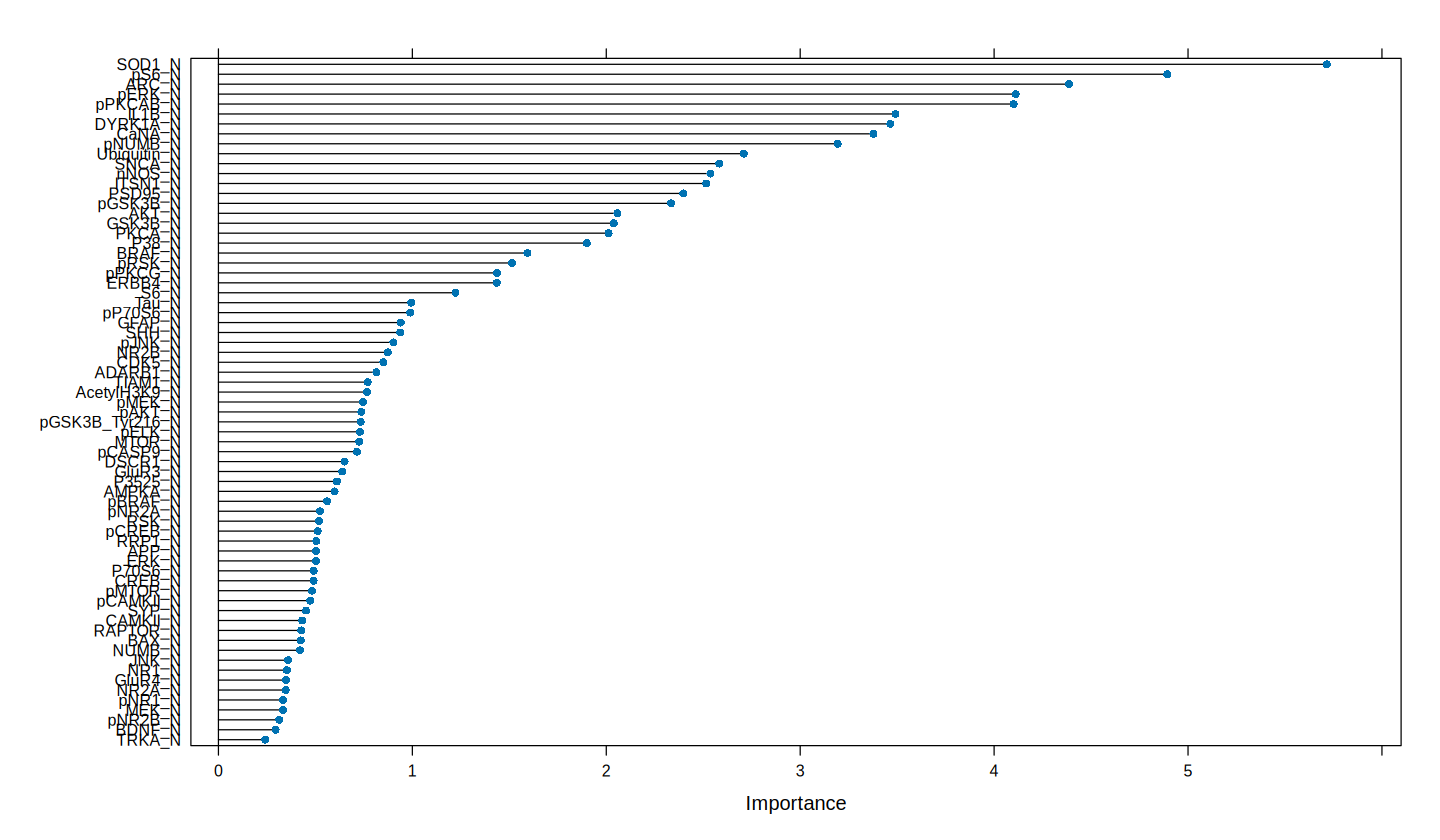

In [22]:
importance <- varImp(model, scale=FALSE)
print(importance)
plot(importance)

## 4. Recursive Feature Elimination

In [27]:
rfe_control <- rfeControl(functions=rfFuncs, method="cv", number=10)

In [28]:
#Mucho tiempo de computación
results <- rfe(trainTransformed[, c(proteinas)], trainTransformed$Behavior, sizes=c(1:69), rfeControl=rfe_control)

In [29]:
results


Recursive feature selection

Outer resampling method: Cross-Validated (10 fold) 

Resampling performance over subset size:

 Variables Accuracy  Kappa AccuracySD KappaSD Selected
         1   0.9897 0.9794    0.02165 0.04348         
         2   1.0000 1.0000    0.00000 0.00000        *
         3   1.0000 1.0000    0.00000 0.00000         
         4   1.0000 1.0000    0.00000 0.00000         
         5   1.0000 1.0000    0.00000 0.00000         
         6   1.0000 1.0000    0.00000 0.00000         
         7   1.0000 1.0000    0.00000 0.00000         
         8   1.0000 1.0000    0.00000 0.00000         
         9   1.0000 1.0000    0.00000 0.00000         
        10   1.0000 1.0000    0.00000 0.00000         
        11   1.0000 1.0000    0.00000 0.00000         
        12   1.0000 1.0000    0.00000 0.00000         
        13   1.0000 1.0000    0.00000 0.00000         
        14   1.0000 1.0000    0.00000 0.00000         
        15   1.0000 1.0000    0.00000 0.00000     

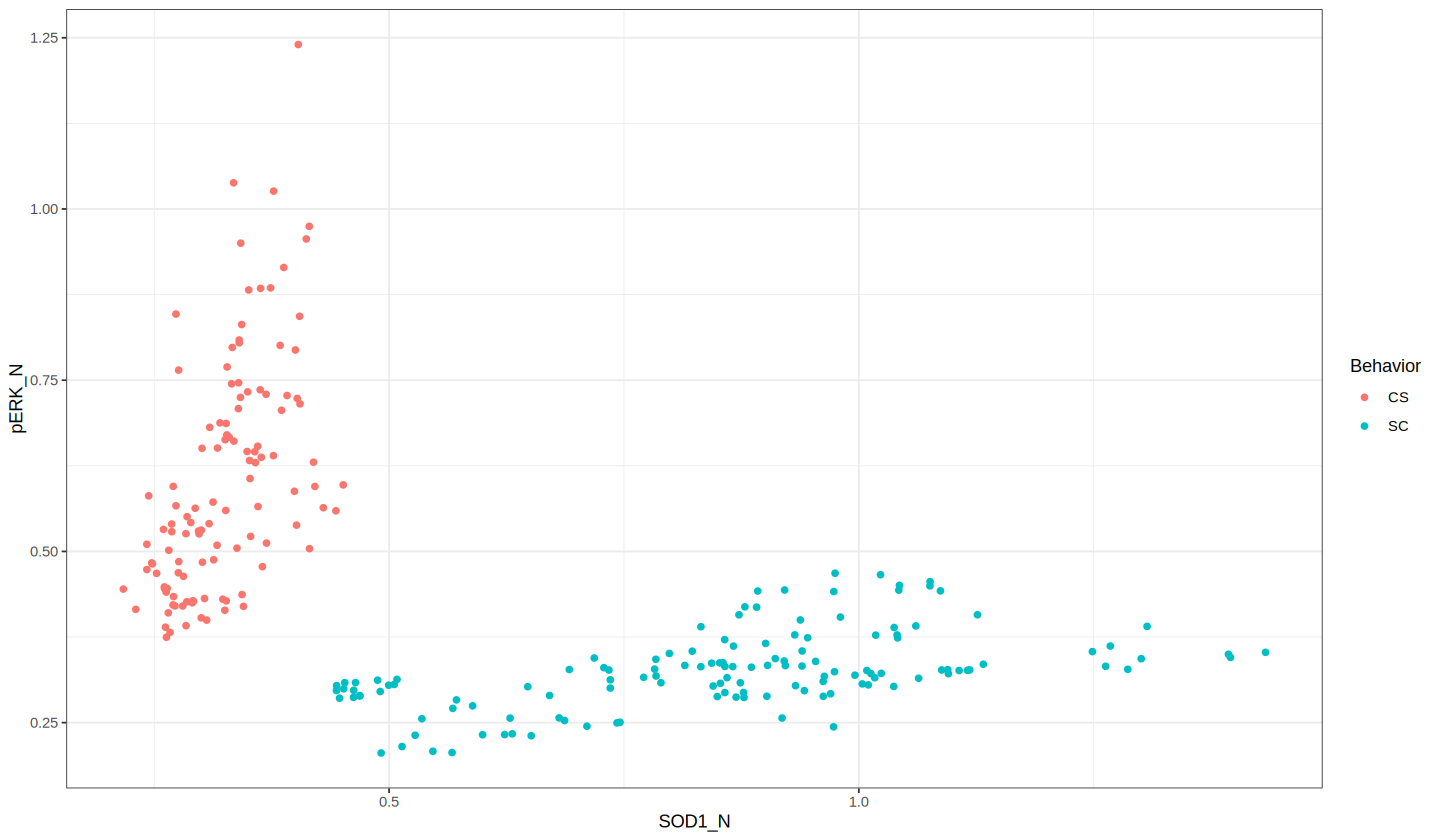

In [32]:
ggplot(df.c_s, aes(x = SOD1_N, y = pERK_N)) +
    geom_point(aes(color = Behavior)) +
    theme_bw()

In [37]:
selected_variables <- orden[1:6]

In [38]:
save.image()